# Import packages and data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import highspy

In [17]:
wind_farm_size = 80   # MW (wind farm installed capacity)
max_import_export_power = wind_farm_size * 0.25   # MW (max import/export limit)

# Wind profile

wind_power_time_series = pd.read_csv("/Users/tilde/OneDrive/Desktop/EG2340/Vestas_production_2024_8760.csv")["Vestas production"].astype(float)
wind_power_time_series = wind_power_time_series*23

# Scaled
load_profile = pd.read_csv(
    "/Users/tilde/OneDrive/Desktop/EG2340/Load_profile.csv"
)
load_time_series = load_profile.loc[:, "Load Profile"].astype(float) * wind_farm_size * 1.2

# Solar profile 
solar_profile = pd.read_csv(
    "/Users/tilde/OneDrive/Desktop/EG2340/Solar_profile.csv"
)
solar_time_series = solar_profile.loc[:, "Solar profile"].astype(float) * wind_farm_size * 0.5

# Prices 
prices = pd.read_csv(
    "/Users/tilde/OneDrive/Desktop/EG2340/Prices_clean.csv"
)
prices = prices.to_numpy() 

T_simulation = 8760

print("Load range:", load_time_series.min(), load_time_series.max())
print("Wind range:", wind_power_time_series.min(), wind_power_time_series.max())
print("Solar range:", solar_time_series.min(), solar_time_series.max())

Load range: 32.10696048 96.0
Wind range: 0.44302600000000003 78.16113
Solar range: 0.00871288 40.0


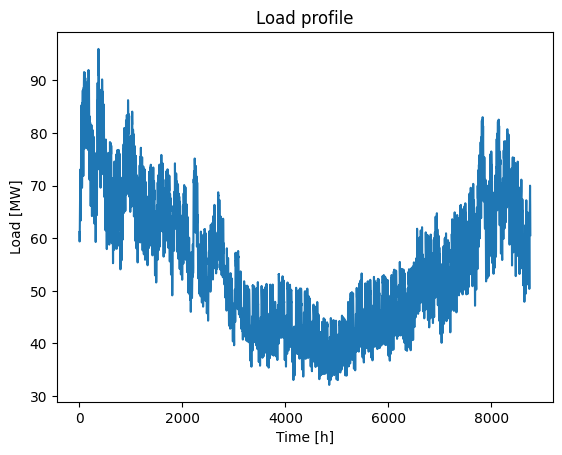

In [18]:
plt.plot(load_time_series)
plt.title("Load profile")
plt.xlabel("Time [h]")
plt.ylabel("Load [MW]")
plt.show()

<Axes: >

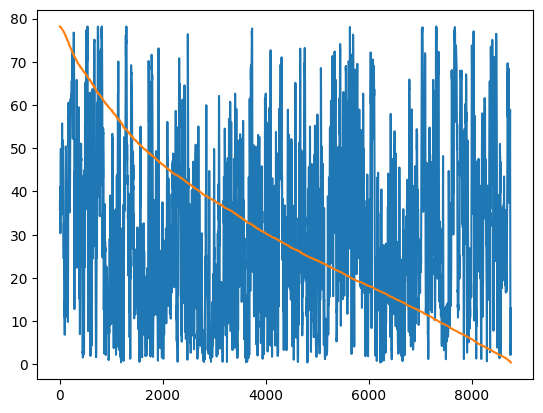

In [19]:
wind_power_time_series.plot()
wind_power_time_series.sort_values(ascending=False).reset_index(drop=True).plot()

# Generate the model 

In [20]:
# General model settings
model = highspy.Highs()

# Parameters
start_storage_percentage = 0.5          # 50% startnivå
storage_cost_per_MWh = 300000           # Kan användas i objective

Maximum_storage = 50
Minimum_storage = 0.1 * Maximum_storage
End_storage = 0.5 * Maximum_storage
max_export = max_import_export_power
max_import = max_import_export_power

# Define variables

charge_in = []
charge_out = []
E_wind = []
storage = []
imported = []
exported = []

for t in range(T_simulation):
    c_in = model.addVariable(lb=0, ub=40, name=f"charge_in_{t}")
    c_out = model.addVariable(lb=0, ub=40, name=f"charge_out_{t}")
    charge_in.append(c_in)
    charge_out.append(c_out)

    s = model.addVariable(lb=Minimum_storage, ub=Maximum_storage, name=f"storage_{t}")
    storage.append(s)

    e = model.addVariable(lb=0, ub=wind_farm_size, name=f"E_wind_{t}")
    E_wind.append(e)

    im = model.addVariable(lb=0, ub=max_import, name=f"import_{t}")
    ex = model.addVariable(lb=0, ub=max_export, name=f"export_{t}")
    imported.append(im)
    exported.append(ex)

# SoC balance
for t in range(T_simulation):
    if t == 0:
        model.addConstr(storage[t] == start_storage_percentage * Maximum_storage)
    else:
        model.addConstr(storage[t] == storage[t-1] + charge_in[t] - charge_out[t])

# Power balance
for t in range(T_simulation):
    model.addConstr(solar_time_series[t] + E_wind[t] + charge_out[t] - charge_in[t] + imported[t] - exported[t] <= load_time_series[t])

# Battery and wind limits
for t in range(T_simulation):
    model.addConstr(storage[t] <= Maximum_storage)
    model.addConstr(storage[t] >= Minimum_storage)
    model.addConstr(E_wind[t] <= wind_power_time_series[t])

# Transmission limits
for t in range(T_simulation):
    model.addConstr(imported[t] <= max_import)
    model.addConstr(exported[t] <= max_export)
    model.addConstr(
        exported[t] <= E_wind[t] + solar_time_series[t] + charge_out[t]
    )



First objective: maximize win without BESS

In [21]:
modelwind = highspy.Highs()

E_wind2 = []
for t in range(T_simulation):
    var = modelwind.addVariable(lb=0, ub=highspy.kHighsInf, name=f"E_wind_{t}")
    E_wind2.append(var)

# Constraints
for t in range(T_simulation):

    # 1. Energy balance: solar + wind sold ≤ load
    modelwind.addConstr(
        solar_time_series[t] + E_wind2[t] + imported[t] - exported[t] <= load_time_series[t]
    )

    # 2. Wind sale cannot exceed physical production
    modelwind.addConstr(
        E_wind2[t] <= wind_power_time_series[t]
    )

    # 3. Export limit (25% of installed capacity)
    modelwind.addConstr(E_wind2[t] >= 0)
    modelwind.addConstr(
        exported[t] <= E_wind2[t] + solar_time_series[t]
    )

    # 3. Export limit (25% of installed capacity)
    modelwind.addConstr(E_wind2[t] >= 0)

total_revenue_wind = 0
for t in range(T_simulation):
    total_revenue_wind += float(prices[t]) * E_wind2[t]

modelwind.changeObjectiveSense(highspy.ObjSense.kMaximize)
modelwind.setObjective(total_revenue_wind)
modelwind.run()

# If you want to see the progress of the solver uncomment the following 2 lines:
#model.setOptionValue("log_file", "highs_log.txt")  # Set log file path
#model.setOptionValue("output_flag", True)          # Enable solver output

# Check if optimal solution was found

if modelwind.getModelStatus() == highspy.HighsModelStatus.kOptimal:
    print("Optimal solution found.")
    solution = modelwind.getObjectiveValue()
else:
    print("No optimal solution found.")

print(solution)


Optimal solution found.
8109064.00335495


C:\Users\tilde\AppData\Local\Temp\ipykernel_18260\2993082606.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_revenue_wind += float(prices[t]) * E_wind2[t]


Second objective: maximize win with BESS

In [22]:
total_revenue = 0
for t in range(T_simulation):
    total_revenue += float(prices[t])*charge_out[t] + float(prices[t])*E_wind[t] - float(prices[t])*charge_in[t] 

model.changeObjectiveSense(highspy.ObjSense.kMaximize)
model.setObjective(total_revenue)
model.run()

if model.getModelStatus() == highspy.HighsModelStatus.kOptimal:
    print("Optimal solution found.")
    solution = model.getObjectiveValue()
else:
    print("No optimal solution found.")

total_revenue = solution - storage_cost_per_MWh * Maximum_storage/25
print(total_revenue)

C:\Users\tilde\AppData\Local\Temp\ipykernel_18260\2769558490.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_revenue += float(prices[t])*charge_out[t] + float(prices[t])*E_wind[t] - float(prices[t])*charge_in[t]


Optimal solution found.
8773278.412476102


In [25]:
# General model settings
model = highspy.Highs()

# Parameters
start_storage_percentage = 0.5          # 50% startnivå
storage_cost_per_MWh = 300000           # Kan användas i objective

Maximum_storage = 50
Minimum_storage = 0.1 * Maximum_storage
End_storage = 0.5 * Maximum_storage
max_export = max_import_export_power
max_import = max_import_export_power

# Define variables

charge_in = []
charge_out = []
E_wind = []
storage = []
imported = []
exported = []

for t in range(T_simulation):
    c_in = model.addVariable(lb=0, ub=40, name=f"charge_in_{t}")
    c_out = model.addVariable(lb=0, ub=40, name=f"charge_out_{t}")
    charge_in.append(c_in)
    charge_out.append(c_out)

    s = model.addVariable(lb=Minimum_storage, ub=Maximum_storage, name=f"storage_{t}")
    storage.append(s)

    e = model.addVariable(lb=0, ub=wind_farm_size, name=f"E_wind_{t}")
    E_wind.append(e)

    im = model.addVariable(lb=0, ub=max_import, name=f"import_{t}")
    ex = model.addVariable(lb=0, ub=max_export, name=f"export_{t}")
    imported.append(im)
    exported.append(ex)

# SoC balance
for t in range(T_simulation):
    if t == 0:
        model.addConstr(storage[t] == start_storage_percentage * Maximum_storage)
    else:
        model.addConstr(storage[t] == storage[t-1] + charge_in[t] - charge_out[t])

# Power balance
for t in range(T_simulation):
    model.addConstr(solar_time_series[t] + E_wind[t] + charge_out[t] - charge_in[t] + imported[t] - exported[t] <= load_time_series[t])

# Battery and wind limits
for t in range(T_simulation):
    model.addConstr(storage[t] <= Maximum_storage)
    model.addConstr(storage[t] >= Minimum_storage)
    model.addConstr(E_wind[t] <= wind_power_time_series[t])

# Transmission limits
for t in range(T_simulation):
    model.addConstr(imported[t] <= max_import)
    model.addConstr(exported[t] <= max_export)
    model.addConstr(
        exported[t] <= E_wind[t] + solar_time_series[t] + charge_out[t]
    )

Third Objective: minimize curtailment

In [26]:
Wind_max = 0
for t in range(T_simulation):
    Wind_max += E_wind[t]

model.changeObjectiveSense(highspy.ObjSense.kMaximize)
model.setObjective(Wind_max)
model.run()

if model.getModelStatus() == highspy.HighsModelStatus.kOptimal:
    print("Optimal solution found.")
    solution = model.getObjectiveValue()
else:
    print("No optimal solution found.")

print(solution)

Optimal solution found.
265916.4993263279
